In [1]:
from scipy.optimize import curve_fit,minimize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# from numba import njit
import argparse
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
# from my_utils.call_data import CAMB
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *
from cosmoprimo import *
import pathlib

# import camb
import scipy.interpolate as interpolate
from scipy import integrate
import math

from tqdm import tqdm
import emcee                    # for MCMC part

import pickle

from my_utils.utils import *

import math
import warnings          # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

# Enable the autoreload extension
%load_ext autoreload

# Set the reloading behavior
%autoreload 2

/global/u1/s/shreeb/BAO_bispectrum/my_utils/utils.py:71: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/global/u1/s/shreeb/BAO_bispectrum/my_utils/utils.py:135: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
Bk=np.load("/global/homes/s/shreeb/BAO_bispectrum/spt_model/data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("/global/homes/s/shreeb/BAO_bispectrum/spt_model/data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn,bao=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn'],Bk['bk_bao']

Bk_molino=np.load("/global/homes/s/shreeb/BAO_bispectrum/Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

Bk_molino=np.load("/global/homes/s/shreeb/BAO_bispectrum/Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

def prepare_pk(k,E,use_glam = False,filepath = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat"):
    if use_glam == False:
        pkcamb = np.loadtxt(filepath)
        fpk,pknmf,pkmf = less_baoPk(pkcamb,k,E)
    else:
        pkmf = pkm
        pknmf = pknm
        fpk = pkm
    
    return k,fpk,pkmf,pknmf

def get_Bk(kk, *args, use_glam = False, filepath =  "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat", bktype = "ratio", model = "SPT"):
    if len(args)==7:
        alpha,f,b1,b2,E,S0,S1 = args
    elif len(args)==6:
        alpha,f,b1,b2,S0,S1 = args
        E = 0
        
    _,_,pkm,pknm = prepare_pk(k, E, use_glam = False, filepath = filepath)
    
    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)

    pkn1=np.interp(alpha*kk[:,0],k,pknm)
    pkn2=np.interp(alpha*kk[:,1],k,pknm)
    pkn3=np.interp(alpha*kk[:,2],k,pknm)
    
    if bktype == "full":
        return  np.array(Bi0(alpha*kk,pk1,pk2,pk3,f,b1,b2,S0,S1,model = model))
    elif bktype == "smooth":
        return np.array(Bi0(alpha*kk, pkn1,pkn2,pkn3,f,b1,b2,S0,S1,model = model))
    elif bktype == "ratio":
        return Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1,model = model)
    else:
        print("Choose one only: full, smooth or ratio")
                  
def curvefit_Bk(kk, bkm,  use_glam = False, filepath =  "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat", bktype = "ratio", model = "SPT"):
    k1,k2,k3=kk[:,0],kk[:,1],kk[:,2]
    r = np.array(k1*k2*k3)**2
    my_model = lambda kk,alpha,f,b1,b2,E,S0,S1 : get_Bk(kk,alpha,f,b1,b2,E,S0,S1,use_glam = False, filepath = filepath, bktype = bktype, model = model)
    b0 = [1, 0, 1, 0, 0, 0, 0]
    bopt, bcov = curve_fit(my_model,kk,bkm,b0,1/r,maxfev=100000)
    fits = my_model(kk,*bopt)
    # _,_,pkmf,pknmf = prepare_pk(k,bopt[-3],use_glam = False)
    return bopt, fits


In [6]:
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0,0.3,kk,bkm,bk,bknm,bkn,bk_mol,bao)


kmax=0.3, kmin=0, nbins=2600, nmocks=922, hf = -0.5482142857142858


In [7]:
cov.shape, len(kg)

((2600, 2600), 2600)

kmax=0.2, kmin=0, nbins=825, nmocks=922, hf = 9.694736842105263
0.6777 /pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat
[1.00409910e+00 4.33360547e+04 1.51499216e+03 3.10361914e+01
 0.00000000e+00 1.58320461e+06 1.75527848e+03] [ 1.02135755e+00 -6.60841827e+04  2.41602957e+05 -5.35207636e-01
  0.00000000e+00 -7.61881475e+04  7.86409733e+03]


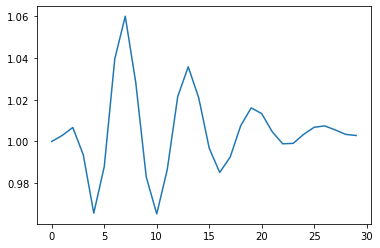

In [154]:
filepaths = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/"
filepath = filepaths + "camb_67773070_matterpower_z0.5_0060.dat"

index = 60
plt.plot(pkm/pknm)
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0,0.2,kk,bkm,bk,bknm,bkn,bk_mol,bao)
icov = np.linalg.inv(bao_cov)
fullbk_bestfits = []
for file in os.listdir(filepaths):
    if file[-3:] == "dat" and file.endswith(f"{index:04}.dat"):
        filepath = os.path.join(filepaths, file)
        h = int(pathlib.PurePath(filepath).name[5:9])/10000
        print(h,filepath)
        bopt_geo, fits_geo = curvefit_Bk(kg,bg/bgn, model = "GEO")
        bopt_spt, fits_spt = curvefit_Bk(kg,bg/bgn, model = "SPT")
        print(bopt_geo, bopt_spt)
        # fullbk_bestfits.append(bopt)

In [155]:
np.savez("params_fits_0.2_2.npz", param_geo = bopt_geo, param_spt = bopt_spt, fits_geo = fits_geo, fits_spt = fits_spt)

In [160]:
fits = np.load("params_fits_0.2_2.npz")
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0.0,0.3,kk,bkm,bk,bknm,bkn,bk_mol,bao)

kmax=0.3, kmin=0.0, nbins=2600, nmocks=922, hf = -0.5482142857142858


In [161]:
bao_spt = get_Bk(kg,*fits['param_spt'],use_glam = False, filepath = filepath, bktype = "ratio", model = "SPT")
bao_geo = get_Bk(kg,*fits['param_geo'],use_glam = False, filepath = filepath, bktype = "ratio", model = "GEO")

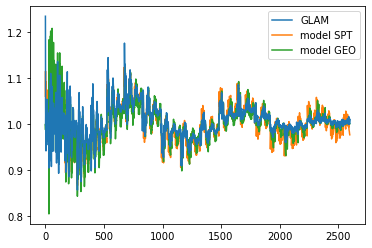

In [152]:
plt.plot(bg/bgn, label = "GLAM", zorder = 3)
plt.plot(bao_spt, label = "model SPT", zorder = 1)
plt.plot(bao_geo, label = "model GEO", zorder = 2)
plt.legend()

In [166]:
fits['param_spt'], fits['param_geo']

(array([ 1.02135755e+00, -6.60841827e+04,  2.41602957e+05, -5.35207636e-01,
         0.00000000e+00, -7.61881475e+04,  7.86409733e+03]),
 array([1.00409910e+00, 4.33360547e+04, 1.51499216e+03, 3.10361914e+01,
        0.00000000e+00, 1.58320461e+06, 1.75527848e+03]))

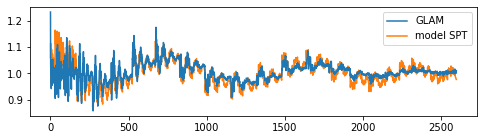

In [165]:
plt.figure(figsize = (8,2))
plt.plot(bg/bgn, label = "GLAM", zorder = 3)
plt.plot(bao_spt, label = "model SPT", zorder = 1)
# plt.plot(bao_geo, label = "model GEO", zorder = 2)
plt.legend()

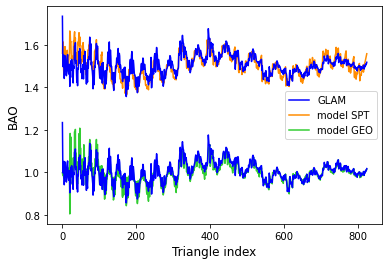

In [149]:
plt.plot(bg/bgn+ 0.5, label = "GLAM",color = "blue", alpha = 1, zorder = 3)
plt.plot(fits["fits_spt"]+0.5, label = "model SPT", color = "darkorange", alpha = 1, zorder = 1)

plt.plot(bg/bgn, color = "blue", alpha = 1, zorder = 3)
plt.plot(fits["fits_geo"], label = "model GEO", color = "limegreen",  alpha =1, zorder = 2)

plt.xlabel("Triangle index", fontsize = 12)
plt.ylabel("BAO", fontsize = 12)
plt.legend()

In [84]:
fits["param_geo"], fits["param_spt"]

(array([1.00409910e+00, 4.33360547e+04, 1.51499216e+03, 3.10361914e+01,
        0.00000000e+00, 1.58320461e+06, 1.75527848e+03]),
 array([ 1.02135755e+00, -6.60841827e+04,  2.41602957e+05, -5.35207636e-01,
         0.00000000e+00, -7.61881475e+04,  7.86409733e+03]))

In [87]:
0.004*100,0.02*100

(0.4, 2.0)